In [9]:
import neptune.new as neptune
from fbprophet import Prophet
import itertools
import pandas as pd
import numpy as np
import sys
import copy
import matplotlib.pyplot as plt

Neptune-FBprophet integration



In [10]:
class NeptuneLogger:
    def __init__(self, run, base_namespace = 'experiment'):
        self.run = run
        self.base_namespace = base_namespace
        self.ns_run = run[self.base_namespace]
        
    def log_config(self, model: Prophet):
        module = "numpy"
        if module not in sys.modules:
            raise Exception(f"{module} is not imported")
            
        config = copy.deepcopy(model.__dict__)
        model.history_dates = pd.DataFrame(model.history_dates)

        with open("trend.npy", 'wb') as f:
            np.save(f, config["params"]["trend"])

        config["params"].pop("trend")
        self.ns_run["config/params/trend"].upload("./trend.npy")

        for key, value in config.items():
            if isinstance(value, pd.DataFrame):
                self.ns_run[f"config/{key}"].upload(neptune.types.File.as_html(value))
            elif isinstance(value, np.ndarray):
                self.ns_run[f"config/{key}"].upload(neptune.types.File.as_html(pd.DataFrame(value)))
            elif isinstance(value, pd.Series):
                self.ns_run[f"config/{key}"].upload(neptune.types.File.as_html(pd.DataFrame(value)))
            else:
                self.ns_run[f"config/{key}"] = value
    

    def log_images(self, name, fig, path=None):
        if self.run.exists(f"{self.base_namespace}/images/{name}"):
            raise ValueError(f"{name} already exists")
        else:
            if path:
                self.ns_run[f"images/{name}"].upload(path)
            else:
                if isinstance(fig, list):
                    if isinstance(fig[-1], plt.Line2D):
                        self.ns_run[f"images/{name}"].upload(neptune.types.File.as_image(fig[-1].figure))
                else:
                    self.ns_run[f"images/{name}"].upload(neptune.types.File.as_image(fig))
            
    def log_df(self, name, df: pd.DataFrame):
        if self.run.exists(f"{self.base_namespace}/dataframes/{name}"):
            raise ValueError(f"{name} already exists")
        else:
            self.ns_run[f"dataframes/{name}"].upload(neptune.types.File.as_html(df))

    def log_artifacts(self, name, path):
        self.ns_run[f"artifacts/{name}"].track_files(path)

In [3]:
run = neptune.init(
    project='common/fbprophet-integration', 
    api_token="ANONYMOUS",
    tags=["fbprophet", "artifacts", "notebook"]    
)

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/common/fbprophet-integration/e/FBPROP-19
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Saturating Forecasts
https://facebook.github.io/prophet/docs/saturating_forecasts.html#forecasting-growth

In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_R.csv")

In [12]:
df["cap"] = 8.5

In [23]:
model = Prophet(growth='logistic')
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.9808


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9006.46      0.012704       469.696           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9014.75     0.0122174       453.437       2.277      0.2277      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9018.94   0.000458159       104.683      0.6529      0.6529      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9019.52   9.46772e-05       91.5897           1           1      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     421       9019.56   6.88623e-05        72.725   9.252e-07       0.001      569  LS failed, Hessian reset 
     444       9019.56   2.64826e-07       72.1751     0.03109      0.8902      6

In [34]:
model.make_future_dataframe(periods=365)

,ds
0,2008-01-01
1,2008-01-02
2,2008-01-03
3,2008-01-04
4,2008-01-05
...,...
3223,2016-12-26
3224,2016-12-27
3225,2016-12-28
3226,2016-12-29


In [35]:
future = model.make_future_dataframe(periods=365*5)
future["cap"] = 8.5

forecast = model.predict(future)
fig = model.plot(forecast)

In [9]:
run = neptune.init(
    project='common/fbprophet-integration', 
    api_token="ANONYMOUS",
    tags=["fbprophet", "saturating forcasts", "notebook"]    
)

https://app.neptune.ai/common/fbprophet-integration/e/FBPROP-2
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [15]:
npt_logger = NeptuneLogger(run)
npt_logger.log_config(model)
npt_logger.log_images("forcast",fig)
npt_logger.log_df("future_df", future)
npt_logger.log_df("input_df", df)

In [8]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.


All 3 operations synced, thanks for waiting!


### Trend Changepoints

[link to docs](https://facebook.github.io/prophet/docs/trend_changepoints.html)

You may have noticed in the earlier examples in this documentation that real time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use.



In [17]:
from fbprophet.plot import add_changepoints_to_plot

changepoint_fig = add_changepoints_to_plot(fig.gca(), model, forecast,)

In [18]:
run = neptune.init(
    project="common/fbprophet-integration", 
    api_token="ANONYMOUS",
    tags=["fbprophet", "trend changepoints", "notebook"]    
)

https://app.neptune.ai/common/fbprophet-integration/e/FBPROP-3
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


**Note**: According to the [docs](https://facebook.github.io/prophet/docs/trend_changepoints.html) changepoints returns a list but they are all the same image so we will only save 1 image. If proven wrong we can save all images in the list.

In [19]:
npt_logger = NeptuneLogger(run)
npt_logger.log_images("changepoint_fig", changepoint_fig)

In [20]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 11 operations to synchronize with Neptune. Do not kill this process.


All 11 operations synced, thanks for waiting!


### Seasonality, Holiday Effects, And Regressors

[link to docs](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html)

In [21]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [22]:
run = neptune.init(
    project="common/fbprophet-integration",
    api_token="ANONYMOUS",
    tags=["fbprophet", "holidays", "notebook"]
)

https://app.neptune.ai/common/fbprophet-integration/e/FBPROP-4
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -24.8456
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9062.99    0.00173004       629.496           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        9086.9     0.0113203       1291.15           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9091.23   0.000784039        203.33           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9092.77   0.000265921       247.462       0.289           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9093.34    6.5219e-05       62.6594       6.015      0.6015      608   
    Iter      log prob        ||dx||      ||grad||       alpha  

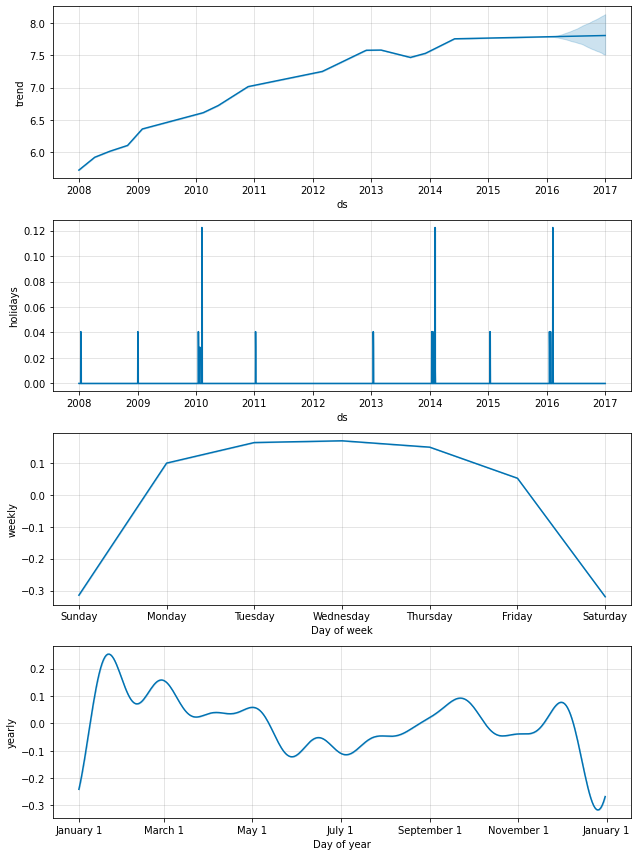

In [23]:
model = Prophet(holidays=holidays)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot_components(forecast)

In [24]:
npt_logger = NeptuneLogger(run)
npt_logger.log_config(model)
npt_logger.log_images("components", fig)
npt_logger.log_df("future_df", future)
npt_logger.log_df("forcast_df", forecast)
npt_logger.log_df("input_df", df)

In [25]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 53 operations to synchronize with Neptune. Do not kill this process.


All 53 operations synced, thanks for waiting!


### Additional regressors

[link to docs](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html)

Additional regressors can be added to the linear part of the model using the add_regressor method or function. A column with the regressor value will need to be present in both the fitting and prediction dataframes. For example, we can add an additional effect on Sundays during the NFL season. On the components plot, this effect will show up in the ‘extra_regressors’ plot:

In [26]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0

df["nfl_sunday"] = df.ds.apply(nfl_sunday)

NFL Sundays could also have been handled using the “holidays” interface described above, by creating a list of past and future NFL Sundays. The add_regressor function provides a more general interface for defining extra linear regressors, and in particular does not require that the regressor be a binary indicator.


Also, you can work with seasonality in the same fashion

```
m = Prophet(seasonality_mode='multiplicative')
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
```

In [27]:
model = Prophet()
model.add_regressor("nfl_sunday")
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -24.8456


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9067.11    0.00239404       1849.62      0.2212      0.2212      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9083.76     0.0136711       937.843           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9089.94     0.0067463       193.767           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9092.92   0.000979435       790.791      0.9034      0.9034      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9094.43    0.00470155       429.495       1.265      0.1265      610   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

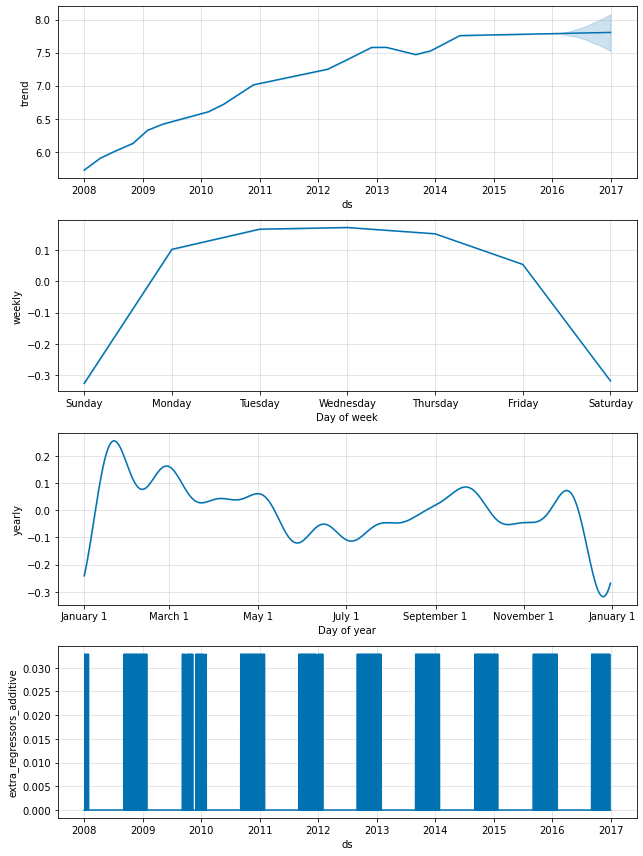

In [28]:
future = model.make_future_dataframe(periods=365)
future["nfl_sunday"] = future.ds.apply(nfl_sunday)
forecast = model.predict(future)
fig = model.plot_components(forecast)

In [29]:
run = neptune.init(
    project='common/fbprophet-integration',
    api_token="ANONYMOUS",
    tags=["fbprophet", "additional regressors", "notebook"]
)

https://app.neptune.ai/common/fbprophet-integration/e/FBPROP-5
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [30]:
npt_logger = NeptuneLogger(run)
npt_logger.log_config(model)
npt_logger.log_images("components", fig)
npt_logger.log_df("future_df", future)
npt_logger.log_df("forcast_df", forecast)
npt_logger.log_df("input_df", df)

In [31]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.


All 5 operations synced, thanks for waiting!


## Hyperparameter tuning
Cross-validation can be used for tuning hyperparameters of the model, such as changepoint_prior_scale and seasonality_prior_scale. A Python example is given below, with a 4x4 grid of those two parameters, with parallelization over cutoffs. Here parameters are evaluated on RMSE averaged over a 30-day horizon, but different performance metrics may be appropriate for different problems.


### Parallelizing cross validation

Cross-validation can also be run in parallel mode in Python, by setting specifying the parallel keyword. Four modes are supported

* parallel=None (Default, no parallelization)
* parallel="processes"
* parallel="threads"
* parallel="dask"

For problems that aren’t too big, we recommend using ```parallel="processes"```. It will achieve the highest performance when the parallel cross validation can be done on a single machine. For large problems, a Dask cluster can be used to do the cross validation on many machines. You will need to install Dask separately, as it will not be installed with prophet.


```
from dask.distributed import Client

client = Client()  # connect to the cluster

df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel="dask")

```

In [32]:
df = pd.read_csv("../example_air_passengers.csv")

In [33]:
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [34]:
from fbprophet.diagnostics import cross_validation, performance_metrics

In [68]:
run = neptune.init(
    project="common/fbprophet-integration",
    api_token="ANONYMOUS",
    tags=["fbprophet", "cross validation", "notebook"]
) 

https://app.neptune.ai/common/fbprophet-integration/e/FBPROP-9
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [57]:
param_grid = {  
    'changepoint_prior_scale': [0.009, 0.01]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

In [69]:
for i, params in enumerate(all_params):
    m = Prophet(**params).fit(df)
    df_cv = cross_validation(m, initial='30 days', horizon='30 days', parallel="threads")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

    npt_logger = NeptuneLogger(run, base_namespace = f"experiment/cv_{i}")

    npt_logger.log_config(m)
    npt_logger.log_df("df", df)
    npt_logger.log_df("df_cv", df_cv)
    npt_logger.log_df("df_p", df_p)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 277 forecasts with cutoffs between 1949-02-02 00:00:00 and 1960-11-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7fe8b8bea250>
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than numbe

/Users/prince_canuma/opt/anaconda3/envs/neptune_prophet/lib/python3.8/site-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/Users/prince_canuma/opt/anaconda3/envs/neptune_prophet/lib/python3.8/site-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


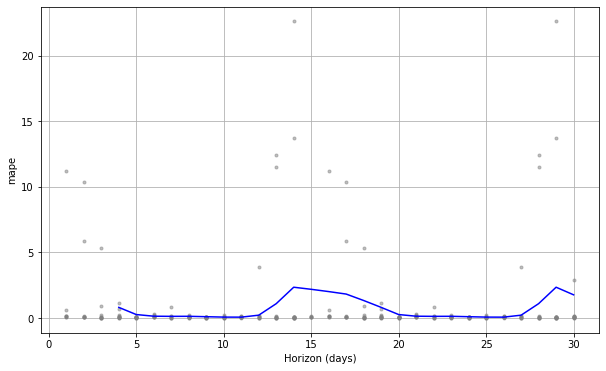

In [70]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [71]:
npt_logger = NeptuneLogger(run)
npt_logger.log_images("cross validation", fig)

In [73]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

ValueError: Length of values (4) does not match length of index (2)

In [74]:
npt_logger.log_df("tuning_results", tuning_results)

In [75]:
best_params = all_params[np.argmin(rmses)]

In [76]:
npt_logger.ns_run["best_params"] = best_params

In [77]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterConnectionError
Communication with Neptune restored!
